In [15]:
import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import os

path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ryanw\.cache\kagglehub\datasets\mahmoudreda55\satellite-image-classification\versions\1


In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=os.path.join(path, "data"), transform=transform)

loader = DataLoader(dataset, batch_size=32, shuffle=True)


Label: cloudy


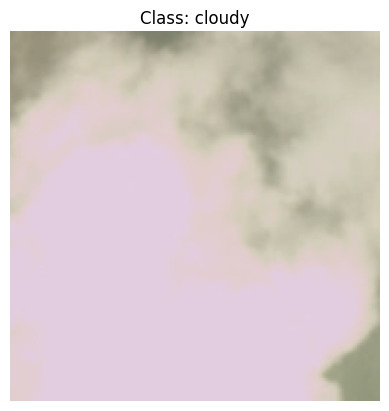

Label: cloudy


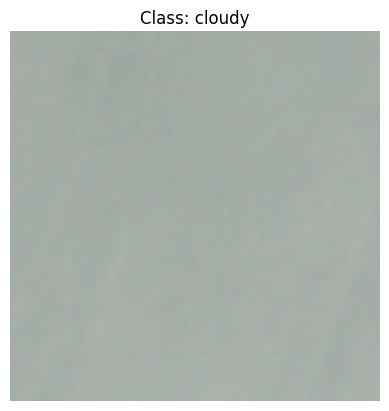

Label: cloudy


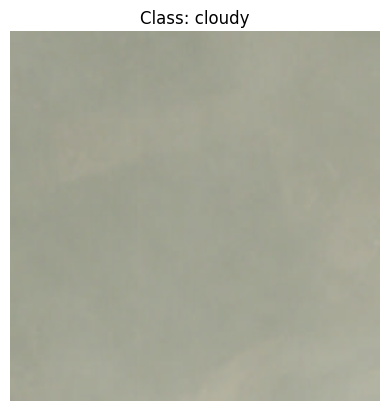

Label: cloudy


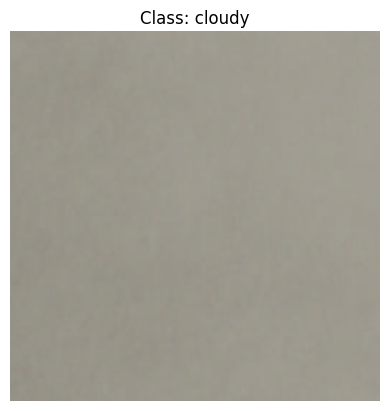

Label: cloudy


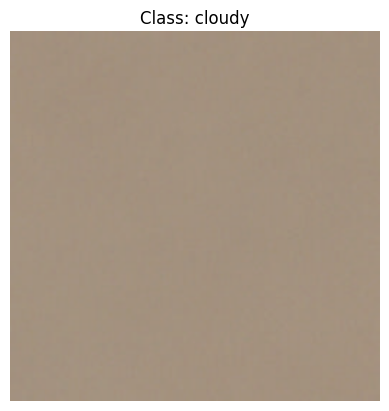

In [18]:
for i in range(5):
    image, label = dataset[i]
    print(f"Label: {dataset.classes[label]}")
    
    # Show the image
    plt.imshow(image.permute(1, 2, 0))  # convert from CxHxW to HxWxC
    plt.title(f"Class: {dataset.classes[label]}")
    plt.axis('off')
    plt.show()

In [17]:
import pandas as pd

# Get the image paths and labels
samples = dataset.samples  # List of tuples: (image_path, class_index)

# Convert to DataFrame
df = pd.DataFrame(samples, columns=["image_path", "label_index"])

# Map class indices to class names
df["class_name"] = df["label_index"].apply(lambda x: dataset.classes[x])

# Show the first 5 rows
print(df.head())
print(dataset.classes)


                                          image_path  label_index class_name
0  C:\Users\ryanw\.cache\kagglehub\datasets\mahmo...            0     cloudy
1  C:\Users\ryanw\.cache\kagglehub\datasets\mahmo...            0     cloudy
2  C:\Users\ryanw\.cache\kagglehub\datasets\mahmo...            0     cloudy
3  C:\Users\ryanw\.cache\kagglehub\datasets\mahmo...            0     cloudy
4  C:\Users\ryanw\.cache\kagglehub\datasets\mahmo...            0     cloudy
['cloudy', 'desert', 'green_area', 'water']
